In [1]:
# import packages and own functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
import os

from Classifier.load_data import load_training_data

from catch22 import catch22_all
import catch22

from scipy.io import wavfile

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV

# may want to try other classifiers eg. logistic regression, SVM, Naive Bayes, etc.
from sklearn.neighbors import KNeighborsClassifier

from Levenshtein import distance as levenshtein_distance

In [2]:
# load in training data

# "C:/Users/souls/Documents/Aqua10/Datasets/Good Data - Sandeep no errors/""

waves, labels, samprate = load_training_data(path = "C:/Users/David/Documents/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow"])

dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'left-right-middle-marina', 'left-right-middle-marina2', 'left-right-middle-marina3', 'left-right-middle-sandeep', 'right-middle']) dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'left-right-middle-marina', 'left-right-middle-marina2', 'left-right-middle-marina3', 'left-right-middle-sandeep', 'right-middle'])


C:\Users\David\Documents\DATA3888\Aqua10\Classifier\load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [3]:
# extract events from training data

# time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

before_buffer = 0.5
after_buffer = 1
    
events = [] # list of events in terms of slice of wav_array
event_labels = [] # list of labels

for key in labels:
    wave = waves[key]
    label = labels[key]
    for lab, time in zip(label.label, label.time):
        event_labels.append(lab)
        event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
        event_end = int((time + after_buffer) * samprate) # in terms of sampling rate

        events.append(wave[event_start:event_end])

In [4]:
# compute catch22 features and convert to dataframe

features = []
for event in events:
    event_ds = event[0::10] # downsample by a rate of 10
    feature = catch22_all(event_ds)
    features.append(feature['values'])

features_df = pd.DataFrame(features)
features_df.columns = feature['names']

<AxesSubplot:>

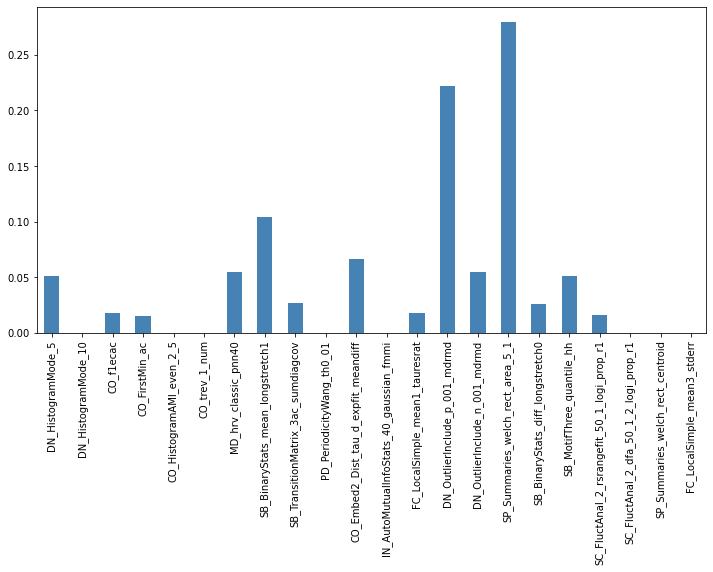

In [6]:
# print(features_df)

clf = DecisionTreeClassifier()
clf.fit(features_df, event_labels)

pd.Series(clf.feature_importances_, index=features_df.columns).plot.bar(color='steelblue', figsize=(12, 6))

In [13]:
# Python SelectFromModel (model based selection)

trans_model = SelectFromModel(clf, threshold='median')
features_trans_model = trans_model.fit_transform(features_df, event_labels)

In [14]:
print(features_trans_model.shape)
columns_retained_FromMode = features_df.iloc[:, :].columns[trans_model.get_support()].values
print(columns_retained_FromMode)

(215, 11)
['DN_HistogramMode_5' 'MD_hrv_classic_pnn40'
 'SB_BinaryStats_mean_longstretch1' 'SB_TransitionMatrix_3ac_sumdiagcov'
 'CO_Embed2_Dist_tau_d_expfit_meandiff' 'FC_LocalSimple_mean1_tauresrat'
 'DN_OutlierInclude_p_001_mdrmd' 'DN_OutlierInclude_n_001_mdrmd'
 'SP_Summaries_welch_rect_area_5_1' 'SB_BinaryStats_diff_longstretch0'
 'SB_MotifThree_quantile_hh']


**11** columns selected using model selection

- DN_HistogramMode_5 
- MD_hrv_classic_pnn40
- SB_BinaryStats_mean_longstretch1
- SB_TransitionMatrix_3ac_sumdiagcov
- CO_Embed2_Dist_tau_d_expfit_meandiff
- FC_LocalSimple_mean1_tauresrat
- DN_OutlierInclude_p_001_mdrmd
- DN_OutlierInclude_n_001_mdrmd
- SP_Summaries_welch_rect_area_5_1
- SB_BinaryStats_diff_longstretch0
- SB_MotifThree_quantile_hh

(What columns are picked vary when the above 2 cells are run, and IDK why, 11 columns seems to be consistent)

In [19]:
# Python step-wise selection


clf = DecisionTreeClassifier()
trans_step = RFECV(clf)
features_trans_step = trans_step.fit_transform(features_df, event_labels)

In [20]:
print(features_trans_step.shape)
columns_retained_step = features_df.iloc[:, :].columns[trans_step.get_support()].values
print(columns_retained_step)

(215, 6)
['SB_BinaryStats_mean_longstretch1' 'CO_Embed2_Dist_tau_d_expfit_meandiff'
 'DN_OutlierInclude_p_001_mdrmd' 'DN_OutlierInclude_n_001_mdrmd'
 'SP_Summaries_welch_rect_area_5_1' 'SB_MotifThree_quantile_hh']


**6** columns selected using RFECV (step-wise selection)

- SB_BinaryStats_mean_longstretch1
- CO_Embed2_Dist_tau_d_expfit_meandiff
- DN_OutlierInclude_p_001_mdrmd
- DN_OutlierInclude_n_001_mdrmd
- SP_Summaries_welch_rect_area_5_1
- SB_MotifThree_quantile_hh

(number of columns and what columns are picked vary when the above 2 cells are run, and IDK why)

In [21]:
selected_features_df = pd.DataFrame(features_trans_step)
selected_features_df.columns = columns_retained_step
selected_features_df['labels'] = event_labels
print(selected_features_df)

     SB_BinaryStats_mean_longstretch1  CO_Embed2_Dist_tau_d_expfit_meandiff  \
0                               335.0                              5.775581   
1                               494.0                              6.578262   
2                               347.0                              7.131774   
3                               366.0                              9.419914   
4                               402.0                              7.158988   
..                                ...                                   ...   
210                             588.0                              9.288320   
211                             565.0                              9.409027   
212                             400.0                             10.273238   
213                             474.0                              8.599096   
214                             502.0                              8.715159   

     DN_OutlierInclude_p_001_mdrmd  DN_OutlierInclu

In [22]:
# save selected feature dataframe as a csv (just load it in for classifier)

selected_features_df.to_csv('catch22_training_data.csv',index=False)

In [23]:
# load csv file

catch_training_data = pd.read_csv("C:/Users/David/Documents/DATA3888/Aqua10/catch22_training_data.csv")
# print(catch_training_data)

     SB_BinaryStats_mean_longstretch1  CO_Embed2_Dist_tau_d_expfit_meandiff  \
0                               335.0                              5.775581   
1                               494.0                              6.578262   
2                               347.0                              7.131774   
3                               366.0                              9.419914   
4                               402.0                              7.158988   
..                                ...                                   ...   
210                             588.0                              9.288320   
211                             565.0                              9.409027   
212                             400.0                             10.273238   
213                             474.0                              8.599096   
214                             502.0                              8.715159   

     DN_OutlierInclude_p_001_mdrmd  DN_OutlierInclu

In [25]:
# catch22_classifier
# assume that an event has been identified and a numpy array has been given
# we will use the four features that RFECV chose

X_train = catch_training_data.iloc[:,0:6]
y_labels = catch_training_data.iloc[:,6]

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_labels)

def catch22_knn_classifier(arr, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist() # single catch22 feature won't take numpy arrays, only lists or tuples
    
    feature_one = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    feature_two = catch22.CO_Embed2_Dist_tau_d_expfit_meandiff(arr_list)
    feature_three = catch22.DN_OutlierInclude_p_001_mdrmd(arr_list)
    feature_four = catch22.DN_OutlierInclude_n_001_mdrmd(arr_list)
    feature_five = catch22.SP_Summaries_welch_rect_area_5_1(arr_list)
    feature_six = catch22.SB_MotifThree_quantile_hh(arr_list)
    
    test_features = [[feature_one, feature_two, feature_three, feature_four, feature_five, feature_six]]
    
    return neigh.predict(test_features)[0] # returns a single item list, so use index 0 to return the prediction itself

In [26]:
# me testing if classifier works

path = 'C:/Users/David/Documents/DATA3888/Aqua10/Datasets/Eye Data/'
file = "left-right"

samprate, wav_array = wavfile.read(path+file+".wav")

# Normalise to +- 512:
wav_array = wav_array/(2**13 - 1)*512
wav_array = np.round(wav_array).astype(np.int)

# plt.plot(wav_array)

test_labels = pd.read_csv(path+file+"..txt", sep=",\t", skiprows=1)

test_labels.columns = ["label", "time"]

# Change depending on whether L is coded as 1 or as 2
test_labels.label = ["L" if label == 1 else "R" for label in test_labels.label]

# test_labels

before_buffer = 0.5
after_buffer = 1

test_events = [] # list of events in terms of slice of wav_array
for time in test_labels.time:
    event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
    event_end = int((time + after_buffer) * samprate) # in terms of sampling rate

    test_events.append(wav_array[event_start:event_end])
    
predictions = []
for event in test_events:
    prediction = catch22_knn_classifier(event)
    predictions.append(prediction)

print(predictions)
predictions_str = ''.join(predictions)

actual = test_labels.label.tolist()
print(actual)
actual_str = ''.join(actual)

levenshtein_distance(predictions_str, actual_str)

['L', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'R']
['L', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'R', 'L', 'L', 'R']


<ipython-input-26-6f07cd567be6>:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_labels = pd.read_csv(path+file+"..txt", sep=",\t", skiprows=1)


2

**References**

https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn

the sklearn documentation

Below here is old code, **IGNORE IT**

In [ ]:

# path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Eye Data/"

# path = 'C:/Users/David/Documents/DATA3888/Aqua10/Datasets/Eye Data/'

# path = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/"

# path = 'C:/Users/souls/Documents/Aqua10/Datasets/Eye Data/'

path = 'C:/Users/souls/Documents/Aqua10/Datasets/Good Data - Sandeep no errors/'

files = os.listdir(path)

# file = "left-right"

waves = {}
labels = {}

for file in files:
    
    if ("right" in file.lower() or "left" in file.lower()) and "blink" not in file.lower() and "eyebrow" not in file.lower():
        if file[-4::] == ".wav":
            samprate, wav_array = wavfile.read(path+file)
            
            # Normalise to +- 512:
            wav_array = wav_array/(2**13 - 1)*512
            wav_array = np.round(wav_array).astype(np.int)

            waves[file[:-4]] = wav_array
            
            
            
        elif file[-4::] == ".txt":
            labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)
            labels_dat.columns = ["label", "time"]
            # Change depending on whether L is coded as 1 or as 2
            labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]

            labels[file[:-4].replace(".", "")] = labels_dat

            
    
# samprate, wav_array = wavfile.read(path+file+".wav")

# # Normalise to +- 512:
# wav_array = wav_array/(2**13 - 1)*512
# wav_array = np.round(wav_array).astype(np.int)

# plt.plot(wav_array)




In [ ]:
# Load in labels


# labels = pd.read_csv(path+file+"..txt", sep=",\t", skiprows=1)

# labels.columns = ["label", "time"]

# # Change depending on whether L is coded as 1 or as 2
# labels.label = ["L" if label == 1 else "R" for label in labels.label]

# labels



In [ ]:
time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate


before_buffer = 0.5
after_buffer = 1

left_events_bool = np.array([False]*len(time_seq))
for time in labels.time[labels.label == "L"]:
    left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    
right_events_bool = np.array([False]*len(time_seq))
for time in labels.time[labels.label == "R"]:
    right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

events = [] # list of events in terms of slice of wav_array
for key in labels:
    for time in labels.time:
        event_start = int((time - before_buffer) * samprate) # in terms of sampling rate
        event_end = int((time+after_buffer) * samprate) # in terms of sampling rate

        events.append(wav_array[event_start:event_end])
    
print(events)
    
plt.figure(figsize=(15, 5))
    
plt.plot(time_seq, wav_array)

plt.fill_between(time_seq, 2500, -2500,
                 where = left_events_bool,
                 color = 'g',
                 alpha=0.2)

plt.fill_between(time_seq, 2500, -2500,
                 where = right_events_bool,
                 color = 'r',
                 alpha=0.2)




# plt.fill_betweenx(ys, start_times, end_times,
#                  facecolor="orange", # The fill color
#                  color='blue',       # The outline color
#                  alpha=0.2)          # Transparency of the fill



In [ ]:
# # Livestreaming data


# # use this to find ports
# import serial
# from serial.tools import list_ports


# ports = list_ports.comports()
# for port in ports:
#     print(port)
    

    
# samprate = 20000
# inputBufferSize = 10000

# # Read example data
# baudrate = 230400
# cport = '/dev/cu.usbmodem142301'  # set the correct port before you run it
# ser = serial.Serial(port=cport, baudrate=baudrate)   


features = []
for event in events:
    event_ds = event[0::10] # downsample by a rate of 10
    feature = catch22_all(event_ds)
    features.append(feature['values'])

features_df = pd.DataFrame(features)



In [ ]:
print(features_df)
# Testing catch22 feature implementation

# keyFeature = []

# for event in events:
#     event_ds = event[0::10] # downsample by a rate of 10
#     event_list = event_ds.tolist()
#     feature = catch22.SB_BinaryStats_mean_longstretch1(event_list)
#     keyFeature.append(feature)

# print(keyFeature)

In [ ]:
# feature selection using decision trees

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

features_df.columns = feature['names']

y = labels.label

clf = DecisionTreeClassifier()
clf.fit(features_df, y)

pd.Series(clf.feature_importances_, index=features_df.columns).plot.bar(color='steelblue', figsize=(12, 6))

trans = SelectFromModel(clf, threshold='median')

# running this a few times, SB_BinaryStats_mean_longstretch1 is the most important while sometimes,
# another feature helps support for a max of 2 features
# results slightly differ with normalisation but are largely the same

In [ ]:
# catch22_classifier
# assume that an event has been identified and a numpy array has been given

def catch22_classifier(arr, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist() # single catch22 feature won't take numpy arrays, only lists or tuples
    
    key_feature = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    
    
    
    

In [ ]:

# SINCE THE STREAMING DATA COMES IN FROM THE RIGHT TO THE LEFT ON THE PLOT, 
# THE RESULTANT PLOT IS ACTUALLY REFLECTED ABOUT THE Y AXIS


samprate = 20000

%matplotlib notebook


# Things you can change:
window_size = 1.5; # time plotted in window [s]
N_loops_over_window = 16 # implicityly defines buffer size so that its 1/<N_loops_over_window>ths of a window

# Things you shouldn't need to change:
inputBufferSize = int(window_size/N_loops_over_window * samprate)

total_time = len(wav_array)/samprate; # time in seconds [[1 s = 20000 buffer size]]
N_loops =(total_time*samprate)//inputBufferSize  # len(wav_array)//inputBufferSize 
T_acquire = inputBufferSize/samprate    # length of time that data is acquired for 
N_loops_over_window = window_size/T_acquire    # total number of loops to cover desire time window



print("total_time", total_time)
print("window_size", window_size)
print("N_loops", N_loops)
print("T_acquire", T_acquire)
print("N_loops_over_window", N_loops_over_window)




# Initialise plot
min_y = -2500 #np.min(wav_array)
max_y = 2500 #np.max(wav_array)
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.ion()
fig.show()
fig.canvas.draw()



for k in range(0,int(N_loops)):
    
    # Simulate stream
    data_temp = read_arduinbro(wav_array, inputBufferSize, k)

    # Stream
#     data = read_arduino(ser,inputBufferSize)
#     data_temp = process_data(data)
    

    if k < N_loops_over_window:
        if k==0:
            data_plot = data_temp
        else:
            data_plot = np.append(data_temp,data_plot)
            
        continue
    else:
        data_plot = np.roll(data_plot,len(data_temp))
        data_plot[0:len(data_temp)] = data_temp
        
    
    
    ## PLOT ###
    
    
    t = (min(k+1,N_loops_over_window))*inputBufferSize/samprate*np.linspace(0,1,(data_plot).size)
    ax1.clear()
    ax1.set_xlim(0, window_size)
    ax1.set_ylim(min_y, max_y)
    plt.xlabel('time [s]')
    ax1.plot(t,data_plot)
    fig.canvas.draw()    
    plt.show()


